# [E-03] 카메라 스티커앱 만들기 첫걸음

이번 프로젝트는 keypoint detection를 통해 사람 이미지에 원하는 이미지를 스티커처럼 붙여넣는 것을 목적으로 한다.

<hr>

## 이미지 사진 불러오기 

먼저 프로젝트에 사용될 라이브러리와 이미지를 불러온다.

In [1]:
# 라이브러리 실행

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

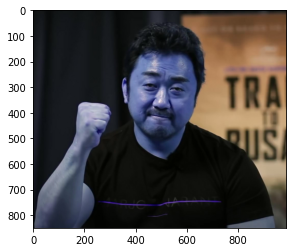

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)
plt.show()

opencv는 이미지 채널을 BGR 순으로 사용하기 때문에 RGB로 바꾸어 색깔 보정처리를 해주어야 한다. 

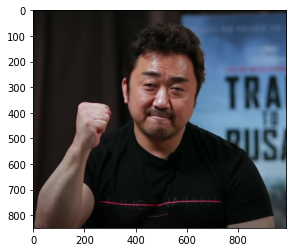

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # 이미지 색 보정처리
plt.imshow(img_rgb)
plt.show()

<hr>

## 얼굴 검출하기

dlib의 face detector는 HOG와 SVM을 사용해 얼굴을 찾아낸다.

In [4]:
# detector 선언

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(379, 231) (646, 498)]]


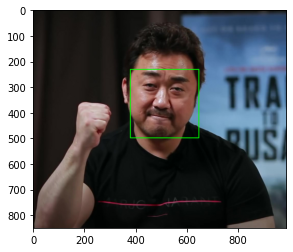

In [5]:
# 찾은 얼굴의 영역을 박스로 표시

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

<hr>

## Face landmark

face landmark는 박스 형태로 검출된 얼굴 이미지를 이용한다. Dlib은 ibug 300w 데이터셋을 사용하였고 이목구비의 위치를 68개의 랜드마크로 표현한다.

In [6]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [7]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아내기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


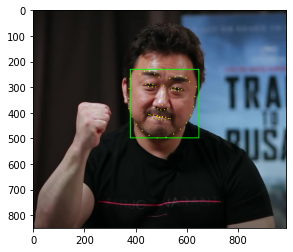

In [8]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [9]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(503, 370)
(x,y) : (503,236)
(w,h) : (268,268)


얼굴 이미지에서 코의 중심점은 (437, 182) 이다.

<hr>

## 스티커 적용하기

준비해 둔 스티커 이미지를 불러와 사진에 붙이는 작업을 한다.

(268, 268, 3)


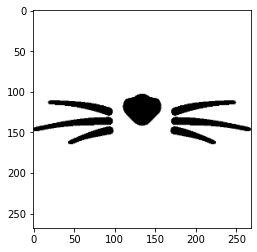

In [10]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)

In [11]:
refined_x = x - w // 2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (369,236)


스티커의 시작점이 음수로 나오는 경우에는 다음의 주석을 사용한다. 음수로 표현되는 경우는 다음과 같다.

1. 스티커의 시작점이 얼굴 사진의 영역을 벗어나는 경우
2. 스티커의 시작점 + 스티커 사진의 크기가 원본 이미지의 크기보다 큰 경우

In [12]:
# if refined_x < 0: 
#     img_sticker = img_sticker[:, -refined_x:]
#     refined_x = 0
# if refined_y < 0:
#     img_sticker = img_sticker[-refined_y:, :]
#     refined_y = 0

# print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

따로 저장해두었던 출력용 이미지 img_show에 스티커를 적용하여 잘 출력되는지 확인해준다.

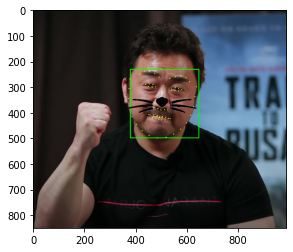

In [13]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

스티커의 위치가 적당한 것을 확인하였으니 bounding box와 landmark를 제거한다.

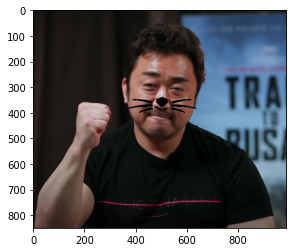

In [14]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

준비한 이미지에 고양이 수염 스티커가 잘 붙은 것을 확인했다.

다음은 여러 가지 변수에 따라 발생할 수 있는 문제점들을 해결해보고자 한다.

시도해 본 변수들은 다음과 같다.

1. 불투명한 스티커 이미지를 투명하게 만들기
2. 스티커을 얼굴 각도에 맞춰 회전시키기
3. 스티커의 색상 변경하기
4. 여러명의 이미지에 스티커를 적용해보기

# 1. 투명도 조절하기

이미지는 위에서 사용한 이미지를 그대로 사용하였다. 스티커의 이미지를 투명하게 변경해주려고 한다.

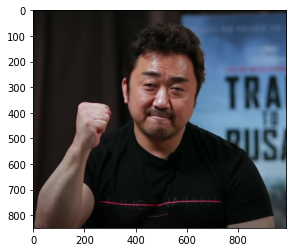

In [15]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # 이미지 색 보정처리
plt.imshow(img_rgb)
plt.show()

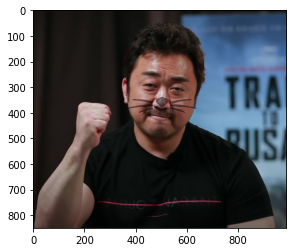

In [16]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

스티커를 투명하게 변경해주었다. 현재 사용한 스티커의 이미지는 크기가 작지만 스티커의 크기가 커질 경우에는 원본 이미지를 가려버리는 경우가 생길 수도 있다.<br>
따라서 필요에 따라 스티커를 투명하게 만들어줄 수 있어야 한다고 생각했다. <br>
cv2.addWeight를 사용해주는 과정에서 0.5라는 가중치를 주었더니 스티커의 이미지가 투명해진 것을 확인할 수 있었다.

<hr>

# 2. 스티커 회전시키기

다음 준비한 이미지를 확인해보면 얼굴의 각도가 기울어져 있어 스티커도 함께 기울여줄 필요가 있어 보인다.

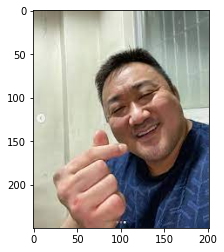

In [17]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_2.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # 이미지 색 보정처리
plt.imshow(img_rgb)
plt.show()

rectangles[[(76, 76) (165, 166)]]


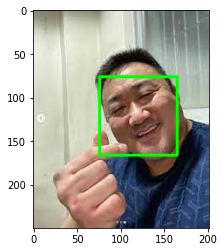

In [18]:
# 찾은 얼굴의 영역을 박스로 표시

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

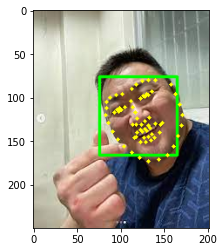

In [19]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아내기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [20]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(119, 124)
(x,y) : (119,79)
(w,h) : (90,90)


(90, 90, 3)


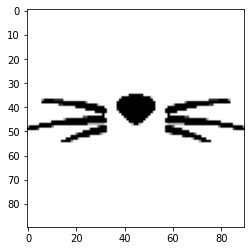

In [21]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)

plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)

In [22]:
refined_x = x - w // 2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (74,79)


여기까지는 이전에 진행한 과정과 크게 다르지 않다.

이제는 랜드마크를 활용해 벡터를 구하고 두 벡터의 각도를 활용하여 스티커 이미지에 적용시킬 예정이다.

In [23]:
landmark = list_landmarks[0]
v1 = np.array([0, 1])
v2 = np.array([abs(landmark[33][0] - landmark[27][0]), abs(landmark[33][1] - landmark[27][1])])
unit_vector_1 = v1 / np.linalg.norm(v1)
unit_vector_2 = v2 / np.linalg.norm(v2)
dot_product = np.dot(unit_vector_1, unit_vector_2)
angle = np.arccos(dot_product)

<function matplotlib.pyplot.show(close=None, block=None)>

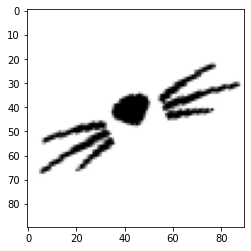

In [24]:
import math

height, width, channel = img_sticker.shape
matrix = cv2.getRotationMatrix2D((width/2, height/2), math.degrees(angle), 1)
img_dsize = cv2.warpAffine(img_sticker, matrix, (width, height), borderValue=(255, 255, 255))

plt.imshow(img_dsize)
plt.show

스티커의 이미지가 얼굴의 각도에 맞게 기울어진 것을 확인할 수 있다.

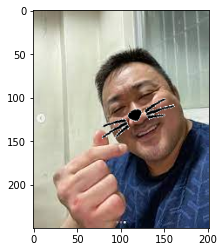

In [25]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_dsize==255,sticker_area,img_dsize).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

스티커 이미지를 회전시킨 것도 원본 이미지에 잘 맞게 출력되었다. 얼굴 사진들이 모두 정면을 똑바로 보고 있으면 좋겠지만 그렇지 않은 것이 당연하기 때문에 각도에 맞게 변화를 주는 작업은 필수라고 생각했다. 하지만 각도에 따라 변화를 주는 작업이 매우 힘들었고 결국 랜드마크를 활용하여 벡터를 구해 각도를 구하는 방법을 선택했다. 벡터를 구하는 과정도 힘들었지만 결과물이 정상적으로 나오게 되어 다행이었다.

<hr>

# 3. 수염 빨갛게 만들기

이번에는 스티커의 이미지의 색상을 빨강으로 변경해줄 예정이다.

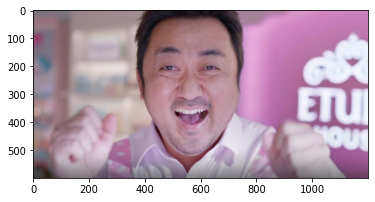

In [26]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_4.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # 이미지 색 보정처리
plt.imshow(img_rgb)
plt.show()

rectangles[[(375, 119) (760, 504)]]


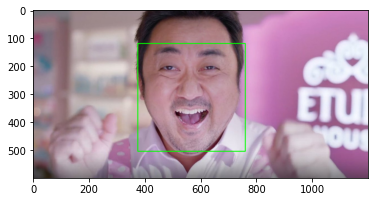

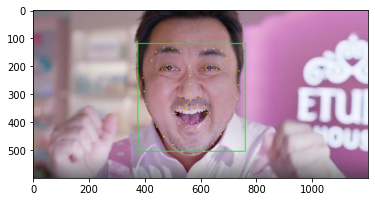

In [27]:
# 찾은 얼굴의 영역을 박스로 표시

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [28]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(563, 296)
(x,y) : (563,103)
(w,h) : (386,386)


(386, 386, 3)


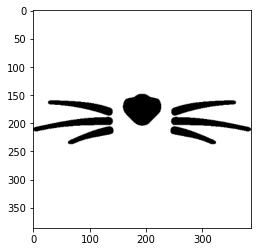

In [29]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)

plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)

In [30]:
refined_x = x - w // 2
refined_y = y
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (370,103)


cv2의 substract 기능을 사용해주었더니 원하는 스티커의 색이 아닌 배경의 색이 변경되었다.

<function matplotlib.pyplot.show(close=None, block=None)>

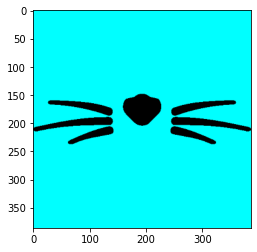

In [31]:
img_dst = cv2.subtract(img_sticker_rgb, 300)
plt.imshow(img_dst)
plt.show

이번엔 cv2의 add 기능을 사용해주었다.

<function matplotlib.pyplot.show(close=None, block=None)>

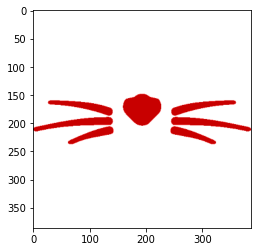

In [32]:
img_dst = cv2.add(img_sticker_rgb, 200)
plt.imshow(img_dst)
plt.show

값을 200으로 설정해두었더니 스티커가 빨강으로 변한 것을 확인할 수 있었다. 하지만 원본 이미지에 적용시켜보니 결과물은 파랑색으로 나왔다.

따라서 cv2.COLOR_BGR2RGB를 통해 색상 보정처리를 해주었다.

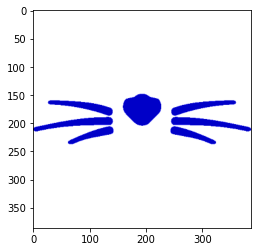

In [33]:
img_dst = cv2.add(img_sticker_rgb, 200)
img_dst = cv2.cvtColor(img_dst, cv2.COLOR_BGR2RGB)
plt.imshow(img_dst)
plt.show()

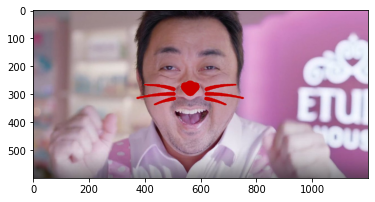

In [34]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_dst==255,sticker_area,img_dst).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

원하는대로 스티커의 색상이 빨강으로 변경된 것을 확인할 수 있다. <br>
이번에 사용된 스티커의 이미지는 검정으로만 이루어졌기 때문에 이 방법이 가능했다고 생각한다.<br>
하지만 여러가지 색상이 들어있는 스티커의 색상을 변경하려면 다른 방법을 찾아봐야 할 것 같다.

<hr>

# 4. 여러 명이 있는 이미지에 적용하기

이번에 한명의 얼굴이 아닌 여러 명의 얼굴을 검출하여 스티커를 적용해볼 예정이다.

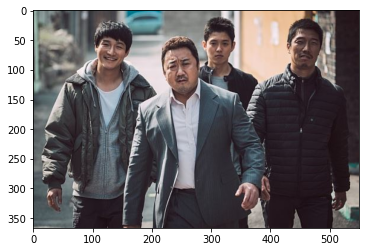

In [35]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_3.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # 이미지 색 보정처리
plt.imshow(img_rgb)
plt.show()

rectangles[[(218, 73) (280, 135)], [(290, 46) (333, 89)], [(435, 38) (487, 90)], [(112, 50) (156, 94)]]


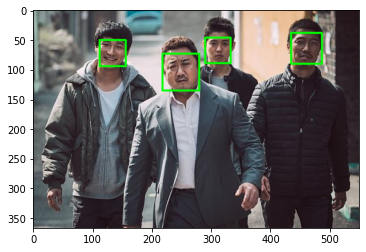

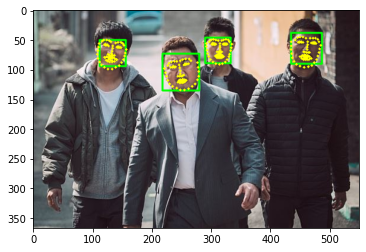

In [36]:
# 찾은 얼굴의 영역을 박스로 표시

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아내기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

여러 얼굴이 존재해도 얼굴 검출이 가능하고 랜드마크가 표시되는 것을 확인했다.

(45, 45, 3)


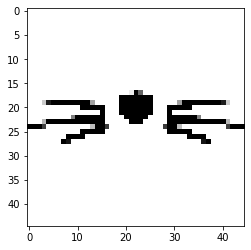

In [37]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)

w = h = dlib_rect.width()
img_sticker = cv2.resize(img_sticker, (w, h))

plt.imshow(img_sticker)
plt.show
print (img_sticker.shape)

(248, 107)
(315, 67)
(462, 66)
(132, 73)


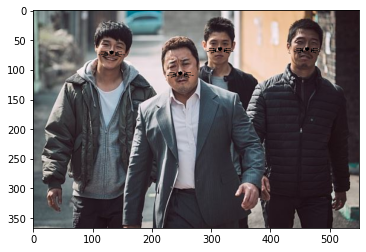

In [38]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) 
    if landmark[30] == (248, 107):
        x = landmark[30][0]
        refined_x = x - w // 2
        y = landmark[30][1] - dlib_rect.height()//2 + 10
        refined_y = y
    elif landmark[30] == (462, 66):
        x = landmark[30][0]
        refined_x = x - w // 2
        y = landmark[30][1] - dlib_rect.height()//2 + 5
        refined_y = y
        
    else:
        x = landmark[30][0]
        refined_x = x - w // 2
        y = landmark[30][1] - dlib_rect.height()//2
        refined_y = y
    sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

얼굴마다 좌표를 구하여 각각의 좌표에 스티커를 적용시키는 작업이 필요했다. 작업은 for문을 활용하였다.<br>
원본이미지에 적용시켜 본 결과 두 번째와 네 번째 얼굴에 적용된 스티커가 살짝 위에 위치하여 부자연스러워 보였다.<br>
따라서 두개의 이미지에는 값을 조정해두었다.<br>

<hr>

## <프로젝트 회고>

자주 사용하던 스티커앱의 기능이 복잡하다는 것을 알게 된 프로젝트였다. 단순해보였던 기술이었지만 생각보다 많은 변수가 존재하였고 최근에는 영상에 바로 적용시켜 동시 출력하는 기능들도 많은데 그런 기술들이 대단하다고 느껴졌다. 이번 프로젝트를 진행하면서 여러 변수들을 해결할 수 있는 방법이 무엇이 있을까 고민을 정말 많이 했다. 물론 결과물을 정상적으로 나왔지만 스티커앱의 기능으로 사용하기에는 많이 부족했다. 

첫 번째 투명하게 만드는 작업은 비교적 오래 걸리지는 않았다. 하지만 세 번째인 색상을 변경해주는 작업은 시간이 정말 많이 소요되었다. 보통은 영상에서 색상을 처리할 때 사용되는 기능들이 많았기 때문이다. 적절한 기능을 찾다가 포기하려는 찰나, 이미지 합성에 사용되는 기능으로 혹시 가능할까 하는 생각에 시도해본 것이 성공했다. 색상 변경을 위한 기능이 아닌 것 같다는 점과 원하는 색상으로 변경하기가 어렵다는 점이 문제였다. 또한 여러 색상이 존재하는 이미지에서도 한계가 있을 것 같다. 

두 번째 작업이었던 스티커를 회전시키는 작업도 여러 방법들이 존재하겠지만 단순하게 벡터로 각도를 구해 적용시켰다. 이번에도 결과물은 원하는대로 나왔지만 원근감을 적용시키지 못한 것이 아쉬웠다. 원근감까지 적용시킬 수 있는 기능이 존재하는 것으로 알고 있기 때문에 다음에 도전해봐야겠다.

마지막은 여러 명의 얼굴에 스티커를 붙이는 작업이었다. 과정은 그렇게 복잡하지는 않았지만 마지막에 각각의 얼굴에 스티커를 적용시키는 작업이 필요했다. 출력된 결과물을 확인해보니 두 명의 얼굴에는 스티커가 부자연스럽게 붙어있었다. 스티커의 위치가 문제였다. 생각해 본 원인으로는 원본 이미지에서 얼굴이 너무 작게 나왔거나 이미지의 질이 좋지 않았던 것으로 보고있다. 물론 정확한 원인을 찾기 위해서는 더 연구해볼 필요가 있어 보인다. 아쉬웠던 점은 스티커의 위치를 바꿔주기 위해 각 이미지에 대한 수정을 해주었다는 점이다. 이번 프로젝트는 스티커앱의 기본적인 기능을 구현해보는 것이 목적이었지만 각각의 이미지에 대한 스티커의 좌표를 수정해준다면 모델을 만드는 의미가 없어지기 때문이다. 

아직은 많이 부족한 실력이라는 것을 프로젝트를 진행하면서 많이 느끼게 되었다. 하지만 여러 문제들을 해결하기 위해 직접 부딪혀보면서 많이 성장하게 된 것 같다.
앞으로의 프로젝트에서도 더 좋은 모델을 만들기 위해 많은 시간을 투자해야겠다는 생각이 들었다.